# Battery Prediction Model - GRU Alternative

This notebook trains a **GRU (Gated Recurrent Unit)** model as an alternative to the LSTM model. GRUs are simpler and faster than LSTMs while often achieving similar performance.

## Model Architecture Comparison:
- **LSTM**: 3 gates (input, forget, output) - more parameters
- **GRU**: 2 gates (update, reset) - fewer parameters, faster training


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [14]:
# Load and prepare data
df = pd.read_csv('synthetic_battery_prediction_data.csv')

feature_cols = ['temperature', 'voltage', 'current', 'power', 'delta_temp', 'delta_voltage', 'delta_current']
target_cols = ['temperature_next', 'voltage_next', 'current_next']

# Scale features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[target_cols])

print(f"Data shape: {X_scaled.shape}")
print(f"Features: {feature_cols}")
print(f"Targets: {target_cols}")


Data shape: (1999, 7)
Features: ['temperature', 'voltage', 'current', 'power', 'delta_temp', 'delta_voltage', 'delta_current']
Targets: ['temperature_next', 'voltage_next', 'current_next']


In [15]:
# Create sequences
seq_length = 10

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
print(f"Sequence shape: {X_seq.shape}")
print(f"Target shape: {y_seq.shape}")


Sequence shape: (1989, 10, 7)
Target shape: (1989, 3)


In [16]:
# Split into train/validation/test (60/20/20)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 1193, Val: 397, Test: 399


In [17]:
# GRU Model Definition with Stronger Regularization
class BatteryGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3, bidirectional=False):
        super(BatteryGRU, self).__init__()
        self.bidirectional = bidirectional
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        # If bidirectional, hidden size is doubled
        gru_output_size = hidden_size * 2 if bidirectional else hidden_size
        # Multiple dropout layers for stronger regularization
        self.dropout1 = nn.Dropout(dropout)
        # Optional: Add a hidden layer with dropout for more regularization
        self.fc1 = nn.Linear(gru_output_size, gru_output_size // 2)
        self.dropout2 = nn.Dropout(dropout * 0.8)  # Slightly less dropout in second layer
        self.fc2 = nn.Linear(gru_output_size // 2, output_size)
        
    def forward(self, x):
        out, _ = self.gru(x)          # out: [batch, seq_len, hidden]
        out = out[:, -1, :]            # take last timestep
        out = self.dropout1(out)       # First dropout
        out = self.fc1(out)            # First FC layer
        out = torch.relu(out)          # Activation
        out = self.dropout2(out)       # Second dropout
        out = self.fc2(out)            # Final output layer
        return out

input_size = X_seq.shape[2]
# Reduced model size to prevent overfitting
hidden_size = 48  # Reduced from 64
num_layers = 2
output_size = y_seq.shape[1]
dropout_rate = 0.35  # Increased from 0.2 for stronger regularization

# Create GRU model (can switch to bidirectional=True for Bidirectional GRU)
model = BatteryGRU(input_size, hidden_size, num_layers, output_size, dropout=dropout_rate, bidirectional=False)

print(f"Model: GRU (with stronger regularization)")
print(f"Input size: {input_size}, Hidden size: {hidden_size}, Layers: {num_layers}")
print(f"Dropout rate: {dropout_rate}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model: GRU (with stronger regularization)
Input size: 7, Hidden size: 48, Layers: 2
Dropout rate: 0.35
Total parameters: 23,571


In [18]:
# Training setup with STRONGER anti-overfitting techniques
criterion = nn.MSELoss()
# Increased weight decay significantly for stronger L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-3)  # Increased from 1e-5 to 1e-3
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=1e-6)

num_epochs = 50
patience = 15  # More patience to allow model to train longer
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

# Gradient clipping to prevent exploding gradients
max_grad_norm = 1.0

print("Starting GRU training with stronger regularization...")
print("-" * 60)
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Gradient clipping: {max_grad_norm}")
print("-" * 60)


Starting GRU training with stronger regularization...
------------------------------------------------------------
Weight decay: 0.001
Initial learning rate: 0.0008
Gradient clipping: 1.0
------------------------------------------------------------


c:\Users\hejer\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
# Training loop with gradient clipping
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gru_model.pth')
    else:
        patience_counter += 1
    
    # Calculate gap percentage for monitoring
    gap_percent = ((avg_val_loss - avg_train_loss) / avg_train_loss) * 100 if avg_train_loss > 0 else 0
    
    print(f"Epoch {epoch+1:3d}/{num_epochs} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | "
          f"Gap: {gap_percent:.1f}% | LR: {optimizer.param_groups[0]['lr']:.6f}", end="")
    print(" *" if patience_counter == 0 else f" (patience: {patience_counter}/{patience})")
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        print(f"Loading best model with val loss: {best_val_loss:.6f}")
        model.load_state_dict(torch.load('best_gru_model.pth'))
        break

print("-" * 60)
print("Training completed!")


Epoch   1/50 | Train: 0.167207 | Val: 0.071872 | Gap: -57.0% | LR: 0.000800 *
Epoch   2/50 | Train: 0.081830 | Val: 0.035029 | Gap: -57.2% | LR: 0.000800 *
Epoch   3/50 | Train: 0.055843 | Val: 0.024094 | Gap: -56.9% | LR: 0.000800 *
Epoch   4/50 | Train: 0.044885 | Val: 0.012255 | Gap: -72.7% | LR: 0.000800 *
Epoch   5/50 | Train: 0.034302 | Val: 0.005225 | Gap: -84.8% | LR: 0.000800 *
Epoch   6/50 | Train: 0.030878 | Val: 0.005790 | Gap: -81.2% | LR: 0.000800 (patience: 1/15)
Epoch   7/50 | Train: 0.028262 | Val: 0.005152 | Gap: -81.8% | LR: 0.000800 *
Epoch   8/50 | Train: 0.026563 | Val: 0.004406 | Gap: -83.4% | LR: 0.000800 *
Epoch   9/50 | Train: 0.025546 | Val: 0.004876 | Gap: -80.9% | LR: 0.000800 (patience: 1/15)
Epoch  10/50 | Train: 0.023790 | Val: 0.004447 | Gap: -81.3% | LR: 0.000800 (patience: 2/15)
Epoch  11/50 | Train: 0.022349 | Val: 0.003779 | Gap: -83.1% | LR: 0.000800 *
Epoch  12/50 | Train: 0.021640 | Val: 0.002497 | Gap: -88.5% | LR: 0.000800 *
Epoch  13/50 | Trai

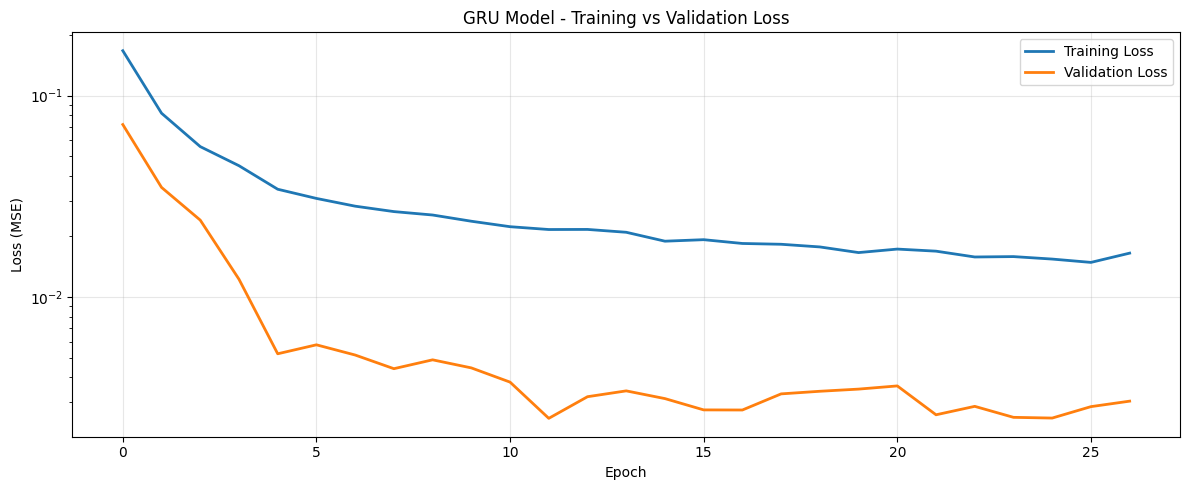


Final Training Loss: 0.016518
Final Validation Loss: 0.003040
Gap: -81.60%
✓ Good generalization


In [20]:
# Plot loss curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('GRU Model - Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
gap_percent = ((final_val_loss - final_train_loss) / final_train_loss) * 100 if final_train_loss > 0 else 0

print(f"\nFinal Training Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Gap: {gap_percent:.2f}%")
print("✓ Good generalization" if gap_percent < 10 else "⚠️ Possible overfitting")


In [21]:
# Evaluate on test set
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        predictions.append(outputs.numpy())
        actuals.append(yb.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Inverse scale
predictions_orig = scaler_y.inverse_transform(predictions)
actuals_orig = scaler_y.inverse_transform(actuals)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actuals_orig, predictions_orig, multioutput='raw_values'))
mae = mean_absolute_error(actuals_orig, predictions_orig, multioutput='raw_values')
r2 = r2_score(actuals_orig, predictions_orig, multioutput='raw_values')

print("GRU Model Performance:")
print("=" * 60)
print(f"Temperature - RMSE: {rmse[0]:.4f} °C, MAE: {mae[0]:.4f} °C, R²: {r2[0]:.4f}")
print(f"Voltage     - RMSE: {rmse[1]:.6f} V,  MAE: {mae[1]:.6f} V,  R²: {r2[1]:.4f}")
print(f"Current     - RMSE: {rmse[2]:.6f} A,  MAE: {mae[2]:.6f} A,  R²: {r2[2]:.4f}")
print("=" * 60)


GRU Model Performance:
Temperature - RMSE: 0.7283 °C, MAE: 0.6176 °C, R²: 0.9832
Voltage     - RMSE: 0.047526 V,  MAE: 0.034493 V,  R²: 0.9741
Current     - RMSE: 0.054206 A,  MAE: 0.040902 A,  R²: 0.9103


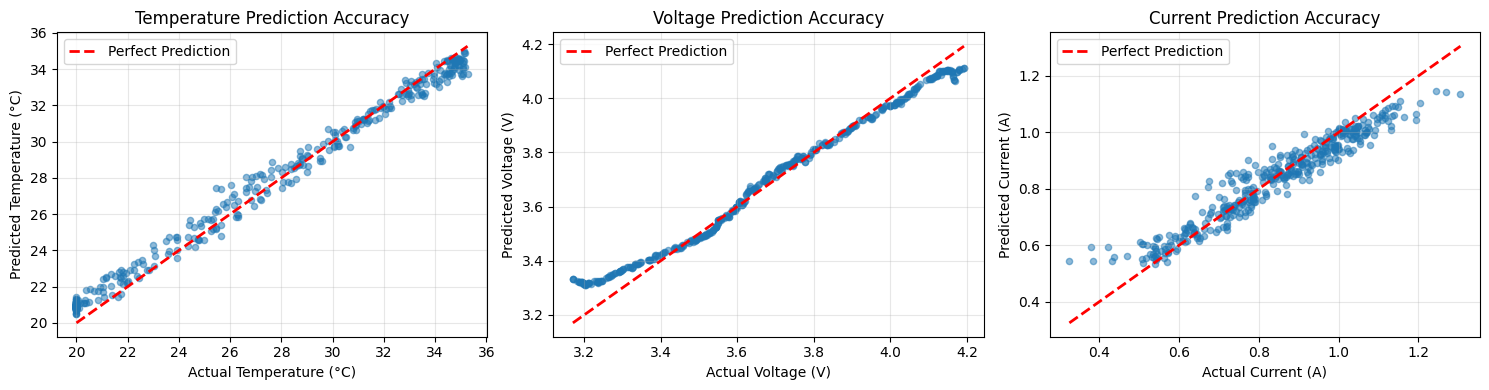

In [22]:
# Scatter plots for model evaluation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

targets = ['Temperature', 'Voltage', 'Current']
units = ['°C', 'V', 'A']

for idx, (target, unit) in enumerate(zip(targets, units)):
    axes[idx].scatter(actuals_orig[:, idx], predictions_orig[:, idx], alpha=0.5, s=20)
    # Perfect prediction line
    min_val = min(actuals_orig[:, idx].min(), predictions_orig[:, idx].min())
    max_val = max(actuals_orig[:, idx].max(), predictions_orig[:, idx].max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[idx].set_xlabel(f'Actual {target} ({unit})')
    axes[idx].set_ylabel(f'Predicted {target} ({unit})')
    axes[idx].set_title(f'{target} Prediction Accuracy')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

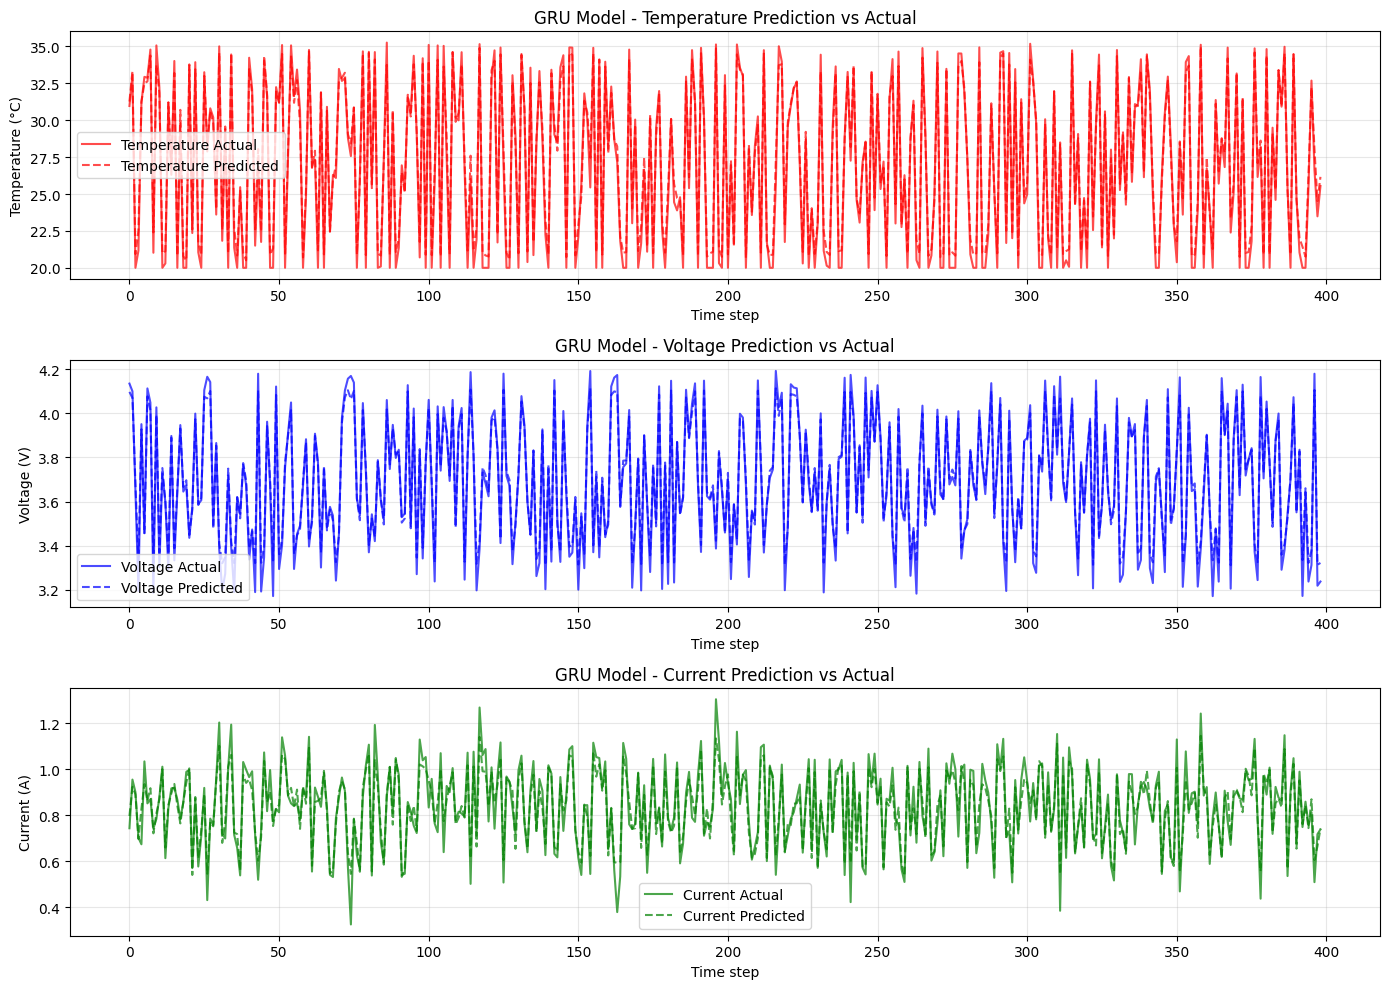

In [23]:
# Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
targets = ['Temperature', 'Voltage', 'Current']
units = ['°C', 'V', 'A']
colors = ['red', 'blue', 'green']

for idx, (target, unit, color) in enumerate(zip(targets, units, colors)):
    axes[idx].plot(actuals_orig[:, idx], label=f'{target} Actual', alpha=0.7, color=color, linewidth=1.5)
    axes[idx].plot(predictions_orig[:, idx], label=f'{target} Predicted', alpha=0.7, color=color, linestyle='--', linewidth=1.5)
    axes[idx].set_xlabel('Time step')
    axes[idx].set_ylabel(f'{target} ({unit})')
    axes[idx].set_title(f'GRU Model - {target} Prediction vs Actual')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [24]:
# Save model and scalers
torch.save(model.state_dict(), 'battery_gru_model.pth')
with open('scaler_X_gru.pkl', 'wb') as f:
    import pickle
    pickle.dump(scaler_X, f)
with open('scaler_y_gru.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

model_params = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'seq_length': seq_length,
    'model_type': 'GRU'
}
with open('model_params_gru.pkl', 'wb') as f:
    pickle.dump(model_params, f)

print("Model and scalers saved successfully!")


Model and scalers saved successfully!


## Experiment with Different Variants

### Try Bidirectional GRU:
Change line in Cell 5:
```python
model = BatteryGRU(..., bidirectional=True)  # Instead of False
```

### Try Different Hyperparameters:
- `hidden_size = 128` (more capacity)
- `num_layers = 3` (deeper network)
- `dropout_rate = 0.3` (more regularization)
- `seq_length = 15` or `20` (longer sequences)

### Other Model Ideas:
1. **CNN-LSTM Hybrid**: Use 1D CNN for feature extraction, then LSTM
2. **Transformer**: Attention-based model (more complex)
3. **Ensemble**: Combine predictions from LSTM and GRU models


## Anti-Overfitting Improvements Applied:

1. **Increased Dropout**: 0.2 → 0.35 (stronger regularization)
2. **Increased Weight Decay**: 1e-5 → 1e-3 (stronger L2 regularization)
3. **Reduced Model Size**: Hidden size 64 → 48 (fewer parameters)
4. **Additional FC Layer**: Added hidden layer with dropout for more regularization
5. **Gradient Clipping**: Prevents exploding gradients (max_norm=1.0)
6. **Lower Learning Rate**: 0.001 → 0.0008 (more stable training)
7. **More Patience**: Allows model to train longer before early stopping


In [25]:
# Test the model with one row of input
print("=" * 60)
print("Testing GRU Model with Single Input Sequence")
print("=" * 60)

# Ensure model is in evaluation mode
model.eval()

# Get the last sequence from the original data (last 10 rows)
# This ensures we have a complete sequence of length 10
test_idx = len(df) - seq_length - 1  # Start index for the sequence
test_data = df.iloc[test_idx:test_idx + seq_length][feature_cols].values

print(f"\nInput sequence shape: {test_data.shape}")
print(f"Input sequence (first row): {test_data[0]}")
print(f"Input sequence (last row): {test_data[-1]}")

# Scale the input sequence using the fitted scaler
test_data_scaled = scaler_X.transform(test_data)

# Reshape to match model input: (batch_size=1, seq_length=10, input_size=7)
test_tensor = torch.tensor(test_data_scaled, dtype=torch.float32).unsqueeze(0)

print(f"\nScaled input tensor shape: {test_tensor.shape}")

# Make prediction
with torch.no_grad():
    prediction_scaled = model(test_tensor)

# Convert to numpy and inverse transform to get original scale
prediction_scaled_np = prediction_scaled.numpy()
prediction_original = scaler_y.inverse_transform(prediction_scaled_np)

# Get the actual next values for comparison
actual_next = df.iloc[test_idx + seq_length][target_cols].values

print("\n" + "=" * 60)
print("PREDICTION RESULTS")
print("=" * 60)
print(f"\nPredicted values (scaled): {prediction_scaled_np[0]}")
print(f"Predicted values (original scale):")
print(f"  Temperature Next: {prediction_original[0][0]:.4f} °C")
print(f"  Voltage Next:     {prediction_original[0][1]:.6f} V")
print(f"  Current Next:     {prediction_original[0][2]:.6f} A")

print(f"\nActual values (original scale):")
print(f"  Temperature Next: {actual_next[0]:.4f} °C")
print(f"  Voltage Next:     {actual_next[1]:.6f} V")
print(f"  Current Next:     {actual_next[2]:.6f} A")

print(f"\nErrors:")
print(f"  Temperature Error: {abs(prediction_original[0][0] - actual_next[0]):.4f} °C")
print(f"  Voltage Error:     {abs(prediction_original[0][1] - actual_next[1]):.6f} V")
print(f"  Current Error:     {abs(prediction_original[0][2] - actual_next[2]):.6f} A")

print("=" * 60)


Testing GRU Model with Single Input Sequence

Input sequence shape: (10, 7)
Input sequence (first row): [ 2.00000000e+01  3.17382904e+00  7.43213930e-01  2.35883396e+00
  0.00000000e+00 -1.33986164e-03  4.68253804e-03]
Input sequence (last row): [ 2.00000000e+01  3.17068279e+00  7.74801799e-01  2.45665073e+00
 -6.89394928e-03  7.46769994e-04  1.69983220e-02]

Scaled input tensor shape: torch.Size([1, 10, 7])

PREDICTION RESULTS

Predicted values (scaled): [0.07854723 0.16072375 0.44080403]
Predicted values (original scale):
  Temperature Next: 21.2090 °C
  Voltage Next:     3.334929 V
  Current Next:     0.755014 A

Actual values (original scale):
  Temperature Next: 20.0000 °C
  Voltage Next:     3.169377 V
  Current Next:     0.818239 A

Errors:
  Temperature Error: 1.2090 °C
  Voltage Error:     0.165552 V
  Current Error:     0.063226 A


c:\Users\hejer\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
